In [14]:

import os
from sktime.benchmarking.forecasting import ForecastingBenchmark
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import MeanSquaredPercentageError, MeanAbsolutePercentageError
from sktime.forecasting.compose import ColumnEnsembleForecaster

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from datetime import datetime

from sktime.split import SlidingWindowSplitter
from sktime.utils.plotting import plot_windows
from sktime.forecasting.base import ForecastingHorizon

from oceanwave_forecast import data_manager, data_pipeline, forecasting_utils

import os
import importlib
import joblib
importlib.reload(data_manager)
importlib.reload(data_pipeline)
importlib.reload(forecasting_utils)

from sktime.transformations.series.impute import Imputer
from sktime.forecasting.arima import ARIMA, AutoARIMA

from sktime.forecasting.model_evaluation import evaluate

from sktime.transformations.series.detrend import Deseasonalizer, Detrender

import os, joblib, optuna, warnings
from pathlib import Path

from sktime.split import temporal_train_test_split
from sktime.transformations.compose import ColumnEnsembleTransformer
from sktime.forecasting.darts import DartsXGBModel 



from xgboost import XGBRegressor
from sktime.forecasting.compose import make_reduction
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, StandardScaler
from sktime.transformations.series.summarize import WindowSummarizer
from sklearn.pipeline import FeatureUnion, Pipeline


# DATA PREPARATION

In [25]:
# Define the paths
folder1_txt = 'D:\\CML\\Term 8\\ML projects\\forecasting_workspace\\oceanwave_forecast\\data\\raw\\Standard meteorological data 2024\\46088h2024.txt'
processed_data_dir = 'D:\\CML\\Term 8\\ML projects\\forecasting_workspace\\oceanwave_forecast\\data\\processed'
pipeline_dir = 'D:\\CML\\Term 8\\ML projects\\forecasting_workspace\\oceanwave_forecast\\models\\pipelines'
MODELS_DIR = 'D:\\CML\\Term 8\\ML projects\\forecasting_workspace\\oceanwave_forecast\\models\\xgb'

data_ocean_raw = data_manager.extract_raw_data(folder1_txt)
data_ocean_raw.info()
processed_data = data_pipeline.preprocess_ocean_data(data_ocean_raw)

# NOTE Truncate the processed data to only include the first 6 months (from Jan 1st to Jun 30th, 2024)
processed_data = processed_data.loc['2024-01-01':'2024-06-30']


processed_data.info()

D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\oceanwave_forecast\data_manager.py:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


DataFrame shape: (52650, 13)

Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52650 entries, 2024-01-01 00:00:00 to 2024-12-31 23:50:00
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WDIR    52650 non-null  float64
 1   WSPD    52650 non-null  float64
 2   GST     52650 non-null  float64
 3   WVHT    52650 non-null  float64
 4   DPD     52650 non-null  float64
 5   APD     52650 non-null  float64
 6   MWD     52650 non-null  float64
 7   PRES    52650 non-null  float64
 8   ATMP    52650 non-null  float64
 9   WTMP    52650 non-null  float64
 10  DEWP    52650 non-null  float64
 11  VIS     52650 non-null  float64
 12  TIDE    52650 non-null  float64
dtypes: float64(13)
memory usage: 5.6 MB

Descriptive statistics:
               WDIR          WSPD           GST          WVHT           DPD  \
count  52650.000000  52650.000000  52650.000000  52650.000000  52650.000000   
mean     194.421026      4.962283      6.

D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\oceanwave_forecast\data_pipeline.py:120: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_ocean_hourly = data_ocean_clean.resample('H').mean()


In [26]:
processed_data_Y = processed_data[['WVHT', 'APD']].copy()
processed_data_X = processed_data.drop(columns=['WVHT', 'APD'])

one_day = 24
one_week = one_day * 7
horizon_steps = one_day*3 # 3 days prediction horizon
training_window = one_week*3  # 3 weeks of training data
fh = ForecastingHorizon(list(range(1, horizon_steps + 1)), is_relative=True)

y_train, y_test, X_train, X_test = temporal_train_test_split(y=processed_data_Y, X=processed_data_X, test_size=horizon_steps*3)


In [27]:

pipe_X, pipe_Y = data_pipeline.get_pipelines(list(X_train.columns))

X_train_transformed = pipe_X.fit_transform(X_train)
X_test_transformed  = pipe_X.transform(X_test)
Y_train_transformed = pipe_Y.fit_transform(y_train)
Y_test_transformed  = pipe_Y.transform(y_test)


Total number of evaluations 4


(<Figure size 1600x480 with 1 Axes>,
 <Axes: xlabel='Time', ylabel='Window number'>)

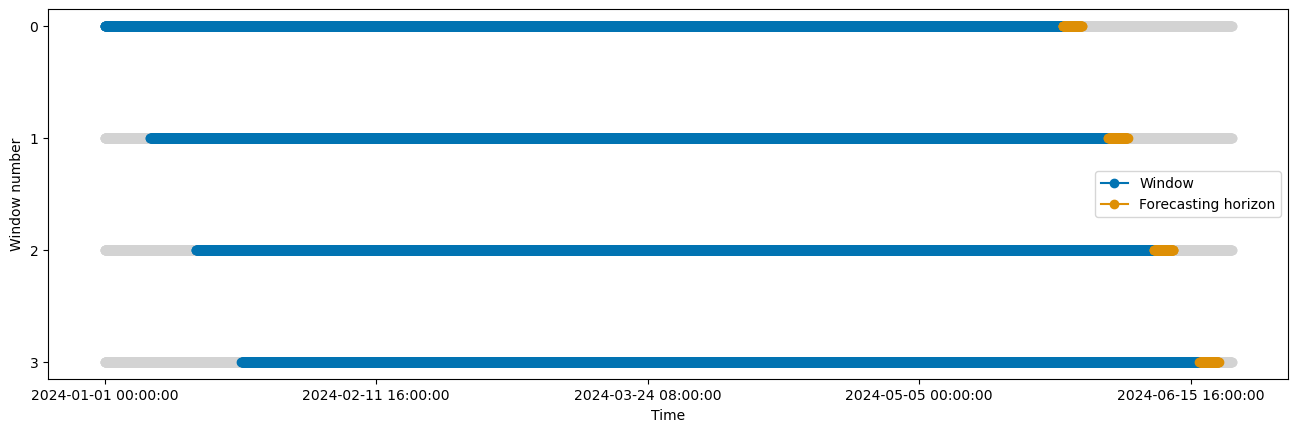

In [31]:


cv = SlidingWindowSplitter(fh=fh, window_length=training_window*7, step_length = one_week)
print("Total number of evaluations",(cv.get_n_splits(Y_train_transformed)))
plot_windows(cv=cv, y=Y_train_transformed[:]) # Plotting for the first 6 weeks of data


# FEATURE ENGG

In [32]:


# --  helpers ---------------------------------------------------
def _add_calendar(X):
    X = X.copy()
    X["month"] = X.index.month
    X["hour"]  = X.index.hour
    return X

calendar_tf = FunctionTransformer(_add_calendar, validate=False)

lag_roll_tf = WindowSummarizer(
    lag_feature = {"lag": [1, 24, 28],
                   "mean": [[1, 24]]},
    truncate    = "bfill",
)

feat_union = FeatureUnion([
    ("calendar", calendar_tf),
    ("lag_roll", lag_roll_tf),
])

feat_pipeline = Pipeline([
    ("features", feat_union),
    ("scaler",   StandardScaler()),
])

# --  build features -------------------------------------------
def make_features(X_scaled, y_scaled, fit=False):
    # Adds the y target varaiables to X so that feature engineering can be done on both
    Xy = pd.concat([pd.DataFrame(X_scaled, index=X_scaled.index, columns=X_train.columns),
                    pd.DataFrame(y_scaled, index=y_scaled.index, columns=y_train.columns)],
                   axis=1)
    if fit:
        # Fit the feature pipeline on the training data
        Xy = feat_pipeline.fit_transform(Xy)
        return pd.DataFrame(Xy, index=X_scaled.index)
    else: 
        # Transform the test data using the fitted pipeline
        Xy = feat_pipeline.transform(Xy)
        return pd.DataFrame(Xy, index=X_scaled.index)


X_feat_train = make_features(X_train_transformed, Y_train_transformed, fit=True)
X_feat_test  = make_features(X_test_transformed,  Y_test_transformed)

# TUNING

In [ ]:
msp_error  = MeanSquaredPercentageError()

# create one timestamp folder for this entire Optuna run
RUN_TS = datetime.now().strftime("%Y%m%d_%H%M%S")
BASE_RUN_DIR = Path(MODELS_DIR) / RUN_TS
BASE_RUN_DIR.mkdir(parents=True, exist_ok=True)


def objective(trial: optuna.Trial) -> float:
    """Fit–evaluate XGBRegressor via make_reduction, return mean MSP error."""
    
    # 1) sample hyper‑params
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1200, step=100),
        "max_depth"   : trial.suggest_int("max_depth", 3, 12),
        "gamma"       : trial.suggest_float("gamma", 0, 5),
        "reg_alpha"   : trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda"  : trial.suggest_float("reg_lambda", 0, 10),
        "objective"   : "reg:squarederror",
        "random_state": 42,
        "n_jobs"      : -1,
    }

    regressor  = XGBRegressor(**params)
    forecaster = make_reduction(
        regressor,
        window_length = training_window,
        strategy      = "recursive",
    )

    # 2) run CV
    results_df = evaluate(
        forecaster     = forecaster,
        y              = Y_train_transformed,
        X              = X_feat_train,
        cv             = cv,
        strategy       = "refit",
        scoring        = [msp_error],
        backend        = "loky",
        backend_params = {"n_jobs": -1},
        return_data    = True,
        return_model   = True,
    )

    # 3) pick best fold
    best_idx, best_model, best_err, y_tr, y_te, y_pr = forecasting_utils.get_best_fold(
        results_df,
        metric="test_MeanSquaredPercentageError"
    )

    # 4) create this trial’s folder
    trial_dir = BASE_RUN_DIR / f"trial_{trial.number:03d}"
    trial_dir.mkdir(exist_ok=True)

    # 5) save full CV results
    results_df.to_csv(trial_dir / "results.csv", index=False)

    # 6) save best model
    joblib.dump(best_model, trial_dir / "model.joblib")

    # (optional) you could also save the best error to a text file
    with open(trial_dir / "best_error.txt", "w") as f:
        f.write(f"{best_err:.6f}")

    return results_df.iloc[:, 0].mean()  # or equivalently best_err if you prefer


# ------------------------------------------------------------------
# 3.  Run the optimisation
# ------------------------------------------------------------------
study = optuna.create_study(
    study_name = "xgb_forecaster_opt",
    direction  = "minimize",         # MSP error → lower is better
)

study.optimize(
    objective,
    n_trials          = 10,         # adjust to taste
    show_progress_bar = True,
)


[I 2025-05-12 23:05:51,803] A new study created in memory with name: xgb_forecaster_opt


  0%|          | 0/10 [00:00<?, ?it/s]

In [19]:

print(f"Best MSP error : {study.best_value:.5f}")
print(f"Best params    : {study.best_params}")
print(f"Best trial     : {study.best_trial.number}")
print(f"Best trial dir : {BASE_RUN_DIR / f'trial_{study.best_trial.number:03d}'}")

Best MSP error : 48.26881
Best params    : {'n_estimators': 700, 'max_depth': 6, 'gamma': 0.7175317112994256, 'reg_alpha': 4.055967718527623, 'reg_lambda': 4.373422369018799}
Best trial     : 6
Best trial dir : D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\models\xgb\20250512_202340\trial_006


In [21]:
final_model_path = BASE_RUN_DIR / f"trial_{study.best_trial.number:03d}" / "model.joblib"
final_model = joblib.load(final_model_path)


# TESTING

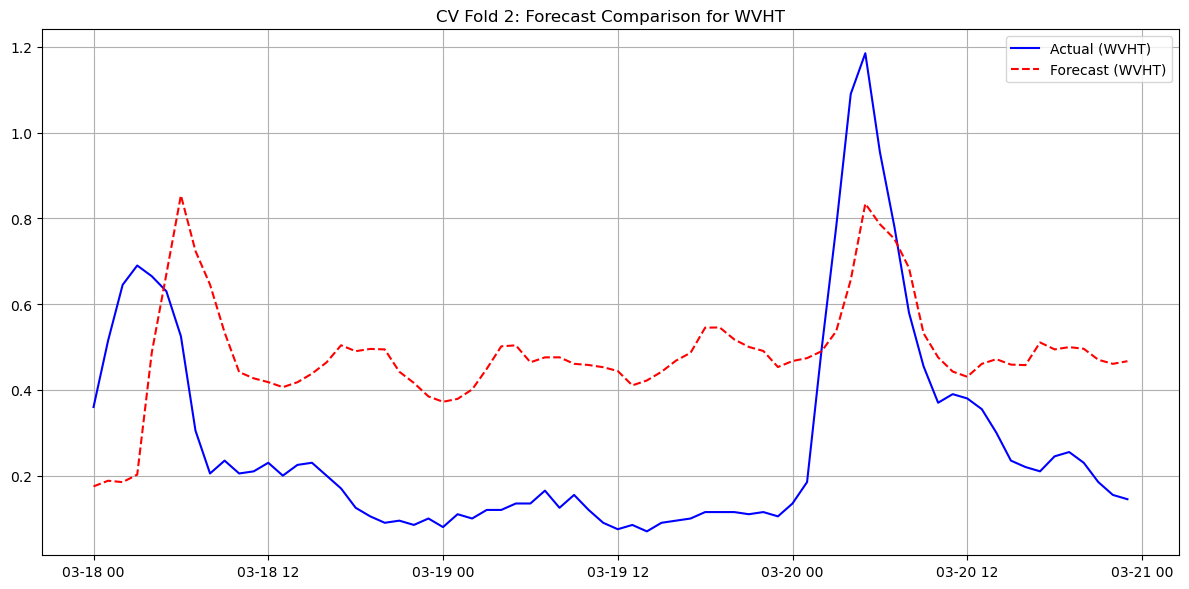

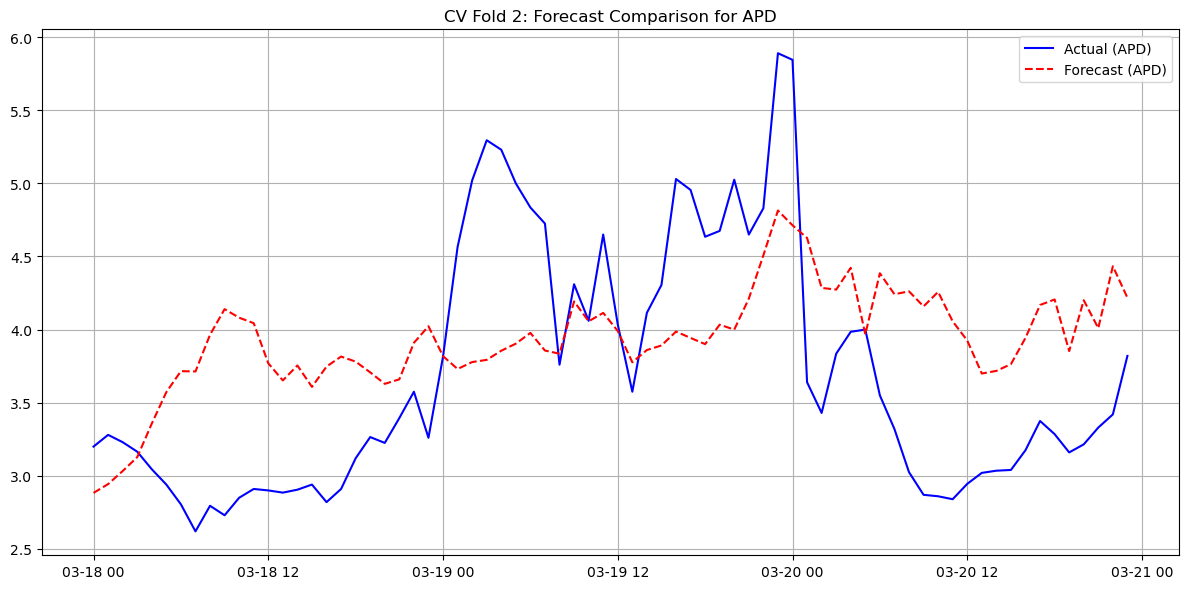

In [ ]:

desired_fold = 2

    # Iterate over the CV folds from the training set
for i, (train_idx, test_idx) in enumerate(cv.split(Y_train_transformed)):
        if i != desired_fold:
            continue  # Skip folds that are not the desired one

        # Select the fold's true values and features
        y_fold_true = Y_train_transformed.iloc[test_idx]
        X_fold = X_feat_train.iloc[test_idx]
        
        # Create a forecasting horizon for the fold (using absolute time stamps)
        fh_fold = ForecastingHorizon(y_fold_true.index, is_relative=False)
        
        # Predict using the final model
        y_fold_pred = final_model.predict(fh=fh_fold, X=X_fold)
        
        # Inverse transform to get back original scale
        y_fold_pred_inv = pipe_Y.inverse_transform(y_fold_pred)
        y_fold_true_inv = pipe_Y.inverse_transform(y_fold_true)
        
        # Plot forecasts vs. actuals for each target variable
        for target in y_fold_true_inv.columns:
            plt.figure(figsize=(12, 6))
            plt.plot(y_fold_true_inv[target], label=f"Actual ({target})", color="blue")
            plt.plot(y_fold_pred_inv[target], label=f"Forecast ({target})", color="red", linestyle="--")
            plt.title(f"CV Fold {i}: Forecast Comparison for {target}")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

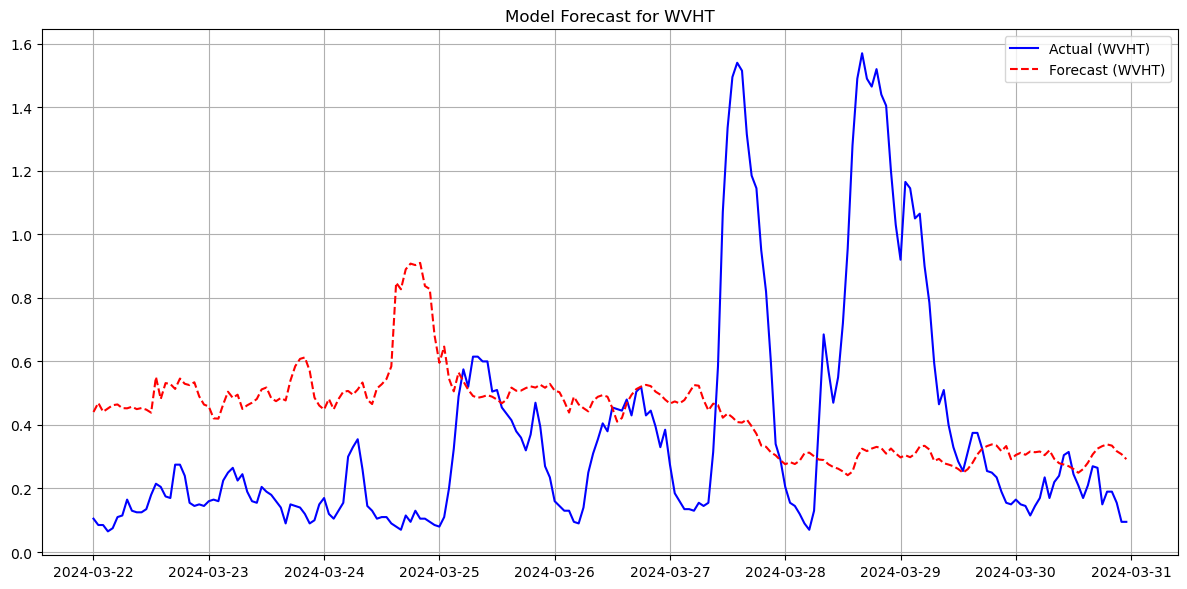

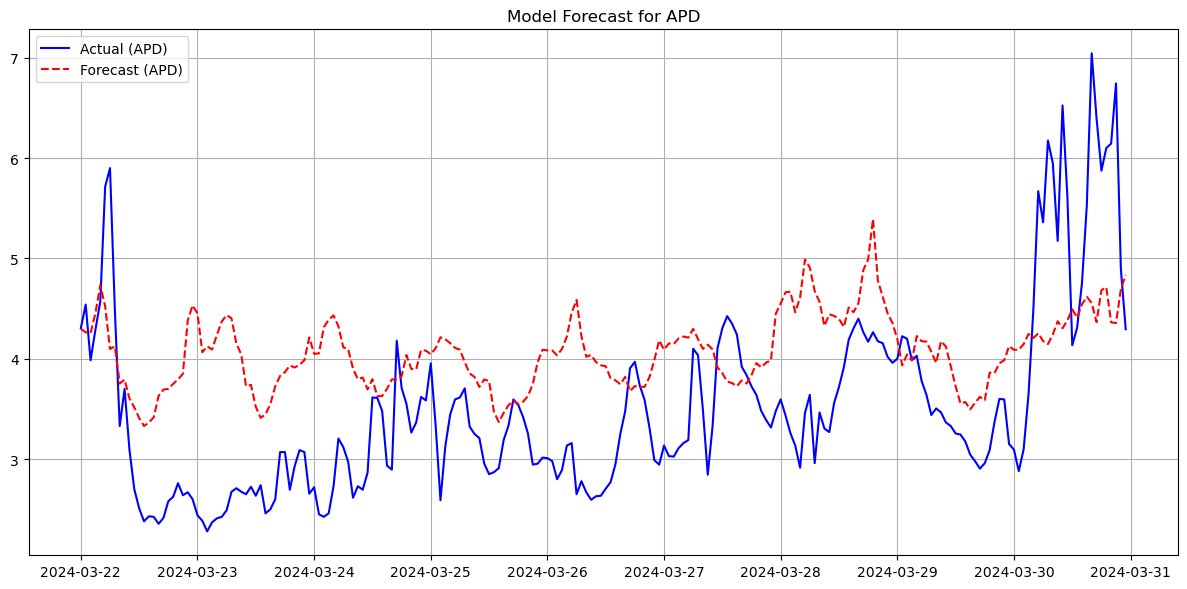

3.0706955987792623


In [22]:
y_pred = final_model.predict(fh=ForecastingHorizon(y_test.index, is_relative=False), X=X_feat_test)
y_pred = pipe_Y.inverse_transform(y_pred)

for target in y_pred.columns:  # Assumes y_pred columns are the target columns
            plt.figure(figsize=(12, 6))
            
            
            # Plot test and predictions
            plt.plot(y_test[target], label=f'Actual ({target})', color='blue')
            plt.plot(y_pred[target], label=f'Forecast ({target})', color='red', linestyle='--')
            
            plt.title(f'Model Forecast for {target}')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


# Calculate and print the Mean Squared Prediction Error (MSPE) for each target
value  = msp_error(y_test, y_pred)
print(value)